In [1]:
import pandas as pd
from pathlib import Path
import inspect 
import numpy as np
import datetime
import os
import json
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from dotmap import DotMap
import torch
import torch.nn.init as init
import torch.nn as nn
import pickle
import torch.autograd as autograd
from torchviz import make_dot
from torchsummary import summary
from termcolor import colored
import seaborn as sns
sns.set()


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics.pairwise import rbf_kernel
from scipy.stats import wasserstein_distance, entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
reserved = int(torch.cuda.max_memory_reserved() / 1000 / 1000)
gpu_available = torch.cuda.is_available()

print(colored(f"GPU available! {torch.cuda.get_device_name()}. Memory reserved: {reserved}MB", "green") if gpu_available else colored("No GPU. Running on CPU", "red"))

GPU available! NVIDIA GeForce RTX 3060. Memory reserved: 0MB


## Research Notes and Progress

**Current Status**
1. Day time model

In [3]:
timestamp = datetime.datetime.now()
timestamp = f"{timestamp.year}-{timestamp.month}-{timestamp.day}_{timestamp.hour}-{timestamp.minute}-{timestamp.second}-{timestamp.microsecond}"

save_dir = Path(timestamp)
if save_dir.exists():
    raise f"Directory exists: {save_dir.as_posix()}"
os.makedirs(save_dir.as_posix())

In [4]:
config = DotMap({"flux_model": "day"})

In [5]:
writer = SummaryWriter(save_dir.joinpath("tensorboard"))

## Model Building and Training

### Data

In [6]:
data = pd.read_parquet("../data_manipulation/final_day_data.parquet")

In [7]:
def set_season_tag(df, isnorth = True):
    if isnorth:
        df["season"] = (df['DateTime'].dt.month%12 + 3) // 3 # print(seasons)
    else:
        df["season"] = ((df['DateTime'].dt.month + 6)%12 + 3)//3
    return df, "season"

def extract_time_features(df):
    """
    Extract features from the timestamp for model training.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    
    Returns:
    pd.DataFrame: DataFrame with extracted features, list: features added to dataframe
    """
    df = df.copy()
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    return df, ["hour", "dayofweek", "month", "dayofyear"]
    
def split_data(df, test_size=0.2):
    """
    Split data into training and test sets.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    test_size (float): Proportion of the data to include in the test split.
    
    Returns:
    tuple: Training and test DataFrames.
    """
    train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [8]:
drivers = np.array(['Ta', 'H', 'Tau', 'LE_strg', 'RH', 'VPD', 'Rg', 'Ustar', 'Tsoil1', 'Tsoil2'])

In [9]:
data, season_feat = set_season_tag(data)
data, time_feat = extract_time_features(data)

In [10]:
data = data[data["dNEE"].notna()].reset_index(drop=True)

In [11]:
data.shape

(28341, 77)

In [12]:
drivers = np.concatenate([drivers, [season_feat], time_feat])

In [13]:
columns_to_check_na = np.concatenate([drivers, ["NEE", "dTa", "dRg"]])

idx = (np.sum(data[columns_to_check_na].notna(), axis=1) == columns_to_check_na.shape[0])
data = data.loc[idx].reset_index(drop=True)

### Training Data 

In [14]:
train_data, test_data = split_data(data)

In [15]:
drivers = np.append(drivers, ["NEE", "E0", "rb", "alpha", "beta"])

In [16]:
X_train = train_data[drivers]
NEE_train = train_data["NEE_next"]
dT_train = train_data["dTa"]
dRg_train = train_data["dRg"]
dNEE_train = train_data["dNEE"]
bNEE_train = train_data["NEE"]
K_train = train_data[["E0", "rb", "alpha", "beta"]]

X_test = test_data[drivers]
NEE_test = test_data["NEE_next"]
dT_test = test_data["dTa"]
dRg_test = test_data["dRg"]
dNEE_test = test_data["dNEE"]
bNEE_test = test_data["NEE"]
K_test = test_data[["E0", "rb", "alpha", "beta"]]


In [17]:
normalizer = StandardScaler()

X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [18]:
with open(save_dir.joinpath("normalizer.pickle"), "wb") as fp:
    pickle.dump(normalizer, fp)

In [19]:
config.data.X = drivers.tolist()
config.data.train_size = X_train.shape[0]
config.data.train_start_date = train_data["DateTime"].iloc[0].ctime()
config.data.train_end_date = train_data["DateTime"].iloc[-1].ctime()
config.data.test_size = X_test.shape[0]
config.data.test_start_date = test_data["DateTime"].iloc[0].ctime()
config.data.test_end_date = test_data["DateTime"].iloc[-1].ctime()


In [20]:
data[["E0", "rb", "alpha", "beta"]].min().astype(np.float16)

E0       50.000000
rb        0.680176
alpha     0.000000
beta      0.000000
dtype: float16

In [21]:
data[["E0", "rb", "alpha", "beta"]].max().astype(np.float16)

E0       249.875000
rb        15.289062
alpha      0.219971
beta     250.000000
dtype: float16

### Model Building

In [22]:
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        # Apply He initialization
        init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
        init.zeros_(layer.bias)

In [23]:
class PIVAE_SDE(nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_dims, decoder_dims, activation=nn.Tanh, hard_z=False):
        super(PIVAE_SDE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.activation = activation
        self.Tref = torch.tensor(10).to("cuda")
        self.T0 = torch.tensor(46.02).to("cuda")
        self.encoder_dims = encoder_dims
        self.decoder_dims = decoder_dims
        self.k_min = torch.tensor([50, 0.0001, 0.0001, 0.0001]).view((-1, 4)).to("cuda")
        self.k_max = torch.tensor([400, 20, 1, 300]).view((-1, 4)).to("cuda")
        self.hard_z = hard_z

        # Encoder network
        modules = self.append_linear_modules(self.input_dim, self.encoder_dims)
        print(modules)
        self.encoder = nn.Sequential(*modules)

        self.fc_mu = nn.Sequential(nn.Linear(self.encoder_dims[-1], latent_dim), activation())
        self.fc_logvar = nn.Sequential(nn.Linear(self.encoder_dims[-1], latent_dim), activation())

         # Decoder network for NEE (u)
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 1))
        self.nee_decoder = nn.Sequential(*modules)
        
        # Decoder network for dT/dt (f)
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 1))
        self.temp_derivative_decoder = nn.Sequential(*modules)

        # Decoder network for dRg/dt (f)
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 1))
        self.radiation_derivative_decoder = nn.Sequential(*modules)
        
        # Decoder network for E0 and rb and alpha and beta
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 4))
        self.k_decoder = nn.Sequential(*modules)
    
    def append_linear_modules(self, in_dim, dims):
        modules = []
        for i, dim in enumerate(dims):
            modules.append(nn.Linear(in_dim, dim))
            if i != len(dims) - 1:
                modules.append(self.activation())
            in_dim = dim
        return modules
        
    def reparameterize(self, mu, logvar):
        if self.hard_z:
            return mu
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        # print("z", torch.mean(z, 0))
        
        nee = self.nee_decoder(z)
        dT_dt = self.temp_derivative_decoder(z)
        dRg_dt = self.radiation_derivative_decoder(z)
        k = self.k_decoder(z)
        # print("k", torch.mean(k, 0))
        k = self.k_min + (self.k_max - self.k_min) * torch.sigmoid(k)
        # print("k", torch.mean(k, 0))
        
        f, residual = self.physics_residual(nee, x, k, x[:, 0].view((-1, 1)), x[:, 1].view((-1, 1)), dT_dt, dRg_dt)
        return nee, dT_dt, dRg_dt, k, f, z, residual

    def physics_residual(self, nee, x, k, T, Rg, dT_dt, dRg_dt):
        E0 = k[:, 0].view((-1, 1))
        rb = k[:, 1].view((-1, 1))
        alpha = k[:, 2].view((-1, 1))
        beta = k[:, 3].view((-1, 1))
        
        # Compute dReco/dT using predicted E0 and rb
        exp_term = torch.exp(E0 * (1.0 / (self.Tref - self.T0) - 1.0 / (T - self.T0))).view((-1, 1))
        dReco_dT = rb * (E0 / (T - self.T0)**2) * exp_term

        # print("dReco_dT", torch.mean(dReco_dT))
        
        # Compute dGpp/dRg using predicted alpha and beta
        # print("Rg", torch.mean(Rg))
        dGpp_dRg = (alpha * beta**2) / (alpha*Rg + beta)**2

        # print("dGpp_dRg", torch.mean(dGpp_dRg))

        # Physics-based residual f = dNEE/dt - (dNEE/dT) * (dT/dt)
        #f_residual = autograd.grad(nee, x, grad_outputs=torch.ones_like(nee), create_graph=True)[:, 0]
        residual = torch.zeros_like(nee) #f_residual - dNEE_dT * dT_dt
 
        f = dReco_dT * dT_dt - dGpp_dRg * dRg_dt

        # print("f", torch.mean(f))
        return f, residual
        # Incorporate boundary condition (NEE_t should be close to NEE_{t-1})

In [24]:
def loss_function(nee_pred, nee_true, latent, z_prior, temp_pred, temp_true, rad_pred, rad_true, k_pred, k_true, f_pred, f_true, physics_residual, loss_fn):
    # MMD Loss for NEE (u)
    mmd_loss_nee = loss_fn(nee_pred, nee_true) + loss_fn(latent, z_prior)

    # MMD Loss for dNEE (f)
    mmd_f_loss = loss_fn(f_pred, f_true)
    
    # MMD Loss for E0 and rb (k)
    E0_pred, rb_pred, alpha_pred, beta_pred = k_pred[:, 0], k_pred[:, 1], k_pred[:, 2], k_pred[:, 3]
    E0_true, rb_true, alpha_true, beta_true = k_true[:, 0], k_true[:, 1], k_true[:, 2], k_true[:, 3]

    mmd_loss_E0 = loss_fn(E0_pred.view((-1, 1)), E0_true.view((-1, 1)))
    mmd_loss_rb = loss_fn(rb_pred.view((-1, 1)), rb_true.view((-1, 1)))
    mmd_loss_alpha = loss_fn(alpha_pred.view((-1, 1)), alpha_true.view((-1, 1)))
    mmd_loss_beta = loss_fn(beta_pred.view((-1, 1)), beta_true.view((-1, 1)))
    
    # MMD loss for temperature derivative (f)
    mmd_temp_loss = loss_fn(temp_pred.view((-1, 1)), temp_true.view((-1, 1)))

    # MMD loss for radiation derivative (f)
    mmd_rad_loss = loss_fn(rad_pred.view((-1, 1)), rad_true.view((-1, 1)))
    
    # Physics-based loss (ensure the solution satisfies the physics model)
    physics_loss = torch.mean(physics_residual ** 2)
    
    # Total loss
    # total_loss = mmd_loss_nee + mmd_loss_E0 + mmd_loss_rb + mmd_temp_loss + physics_loss + mmd_f_loss
    return mmd_loss_nee, mmd_loss_E0, mmd_loss_rb , mmd_loss_alpha, mmd_loss_beta, mmd_temp_loss , mmd_rad_loss, physics_loss , mmd_f_loss


In [25]:
class MMD_loss(nn.Module):
    'description'
    # function class which calculates the MMD distance of 2 distributions

    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()

        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    
    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)

        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [26]:
class ClimateDataset(Dataset):
    def __init__(self, X, k, dNEE, bNEE, dT, dRg, NEE):
        """
        Args:
            X (numpy array): Input data of shape (n_samples, input_dim)
            k (numpy array): Ground truth for E0, rb, alpha and beta shape (n_samples, 4)
            dNEE (numpy array): Ground truth for f, shape (n_samples, 1)
            bNEE (numpy array): Ground truth for NEE at current t (boundary condition), shape (n_samples, 1)
            dT (numpy array): Ground truth for temperature derivative, shape (n_samples, 1)
            dRg (numpy array): Ground truth for radiation derivative, shape (n_samples, 1)
            NEE (numpy array): Ground truth for NEE at t + 1, shape (n_samples, 1)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.k = torch.tensor(k, dtype=torch.float32)
        self.dNEE = torch.tensor(dNEE, dtype=torch.float32)
        self.bNEE = torch.tensor(NEE, dtype=torch.float32)
        self.dT = torch.tensor(dT, dtype=torch.float32)
        self.dRg = torch.tensor(dRg, dtype=torch.float32)
        self.NEE = torch.tensor(NEE, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Get current NEE and previous NEE for boundary condition
        NEE_current = self.NEE[idx]
        
        return {
            'X': self.X[idx],
            'k': self.k[idx],
            'dNEE': self.dNEE[idx],
            'bNEE': self.bNEE[idx],
            'dT': self.dT[idx],
            'dRg': self.dRg[idx],
            'NEE': NEE_current
        }


### Training Setup

In [27]:
lr = 1e-3

model = PIVAE_SDE(input_dim=X_train.shape[1], latent_dim=32, encoder_dims=[16, 32], decoder_dims = [16, 16], hard_z=True,activation=nn.ReLU)
model.apply(initialize_weights)
with open(save_dir.joinpath("model.txt"), "w") as fp:
    fp.write(str(model))

model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Assuming X, k, dNEE, dT, and NEE are numpy arrays you have
train_dataset = ClimateDataset(X_train, K_train.values, dNEE_train.values, bNEE_train.values, dT_train.values, dRg_train.values, NEE_train.values)
test_dataset = ClimateDataset(X_test, K_test.values, dNEE_test.values, bNEE_test.values, dT_test.values, dRg_test.values, NEE_test.values)

# Create a DataLoader instance
train_data_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

[Linear(in_features=20, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=32, bias=True)]


In [28]:
model

PIVAE_SDE(
  (encoder): Sequential(
    (0): Linear(in_features=20, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
  (fc_mu): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (fc_logvar): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (nee_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
  (temp_derivative_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
  (radiation_derivative_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_featu

In [29]:
loss_fn = MMD_loss()

config.model.activation = str(model.activation)
config.model.lr = lr
config.model.loss_fn = str(loss_fn)

with open(save_dir.joinpath("loss_function.txt"), "w") as fp:
    fp.write(inspect.getsource(loss_function))

In [30]:
for i, batch in enumerate(train_data_loader):
    x = batch['X'].to("cuda")
    k = batch['k'].to("cuda")
    f = batch['dNEE'].to("cuda")
    b = batch['bNEE'].to("cuda")
    yhat = model(x)
    if i == 2:
        break
make_dot(yhat, params=dict(list(model.named_parameters()))).render(save_dir.joinpath("pivae"), format="png")

'2024-8-31_13-9-18-280705/pivae.png'

In [31]:
num_epochs = 1000
patience = 50
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience)

config.training.patience = patience
config.training.num_epochs = num_epochs

In [32]:
with open(save_dir.joinpath("config.json"), "w") as fp:
    json.dump(config.toDict(), fp)

### Training

In [33]:
best_test_loss = float('inf')
best_model_path = save_dir.joinpath('best_model.pth')

In [34]:
epoch = 0

##### Control Room

In [85]:
# CONTROL ROOM
# loss_fn = MMD_loss()
model.hard_z = True
loss_fn = nn.L1Loss() #nn.MSELoss()
for g in optimizer.param_groups:
    g['lr'] = 0.00001

##### Back to training

In [86]:
loss_name = "MAE" if str(loss_fn) == 'L1Loss()' else "MMD"

while epoch < num_epochs:

    train_loss = []
    test_loss = []
    
    train_losses = DotMap({"mmd_loss_nee": [], "mmd_loss_E0": [], "mmd_loss_rb": [] , "mmd_loss_alpha": [], "mmd_loss_beta": [], "mmd_temp_loss": [] , "mmd_rad_loss": [], "physics_loss": [] , "mmd_f_loss": []})
    # Example of iterating over the DataLoader in the training loop
    for batch in train_data_loader:
        x = batch['X'].to("cuda")
        k = batch['k'].to("cuda")
        f = batch['dNEE'].to("cuda")
        b = batch['bNEE'].to("cuda")
        dtemp = batch['dT'].to("cuda")
        dRg = batch['dRg'].to("cuda")
        nee = batch['NEE'].to("cuda")
                
        nee_pred, dT_dt_pred, dRg_dt_pred, k_pred, f_pred, z, residual = model(x)
        
        # Extract E0,rb,alpha,beta predictions
        E0_pred, rb_pred, alpha_pred, beta_pred = k_pred[:, 0], k_pred[:, 1], k_pred[:, 2], k_pred[:, 3]

        z_prior = torch.randn_like(z)
        # Compute loss
        
        mmd_loss_nee, mmd_loss_E0, mmd_loss_rb , mmd_loss_alpha, mmd_loss_beta, mmd_temp_loss , mmd_rad_loss, physics_loss , mmd_f_loss = loss_function(nee_pred, nee.view(-1, 1), z, z_prior, dT_dt_pred, dtemp.view(-1, 1), dRg_dt_pred, dRg.view(-1, 1), k_pred, k, f_pred, f.view(-1, 1), residual, loss_fn)
        loss = mmd_loss_nee + mmd_loss_E0 + mmd_loss_rb  + mmd_loss_alpha + mmd_loss_beta + mmd_temp_loss  + mmd_rad_loss + physics_loss  + mmd_f_loss

        train_losses.mmd_loss_nee.append(mmd_loss_nee)
        train_losses.mmd_loss_E0.append(mmd_loss_E0)
        train_losses.mmd_loss_rb.append(mmd_loss_rb)
        train_losses.mmd_loss_alpha.append(mmd_loss_alpha)
        train_losses.mmd_loss_beta.append(mmd_loss_beta)
        train_losses.mmd_temp_loss.append(mmd_temp_loss)
        train_losses.mmd_rad_loss.append(mmd_rad_loss)
        train_losses.physics_loss.append(physics_loss)
        train_losses.mmd_f_loss.append(mmd_f_loss)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().detach().numpy())
    
    print(colored("Training Loss: {}".format(np.mean(train_loss)), "blue"))
    writer.add_scalar(f"Train Loss {loss_name}", np.mean(train_loss), epoch)
    
    for col in train_losses.keys():
        l = [x.cpu().detach().numpy() for x in train_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Train Loss [{col}] {loss_name}", np.mean(l), epoch)
    print("\n")

    test_losses = DotMap({"mmd_loss_nee": [], "mmd_loss_E0": [], "mmd_loss_rb": [] , "mmd_loss_alpha": [], "mmd_loss_beta": [], "mmd_temp_loss": [] , "mmd_rad_loss": [], "physics_loss": [] , "mmd_f_loss": []})
    for batch in test_data_loader:
        x = batch['X'].to("cuda")
        k = batch['k'].to("cuda")
        f = batch['dNEE'].to("cuda")
        dtemp = batch['dT'].to("cuda")
        dRg = batch['dRg'].to("cuda")
        nee = batch['NEE'].to("cuda")
                
        nee_pred, dT_dt_pred, dRg_dt_pred, k_pred, f_pred, z, residual = model(x)
        
        # Extract E0,rb,alpha,beta predictions
        E0_pred, rb_pred, alpha_pred, beta_pred = k_pred[:, 0], k_pred[:, 1], k_pred[:, 2], k_pred[:, 3]

        z_prior = torch.randn_like(z)
        # Compute loss
        
        mmd_loss_nee, mmd_loss_E0, mmd_loss_rb , mmd_loss_alpha, mmd_loss_beta, mmd_temp_loss , mmd_rad_loss, physics_loss , mmd_f_loss = loss_function(nee_pred, nee.view(-1, 1), z, z_prior, dT_dt_pred, dtemp.view(-1, 1), dRg_dt_pred, dRg.view(-1, 1), k_pred, k, f_pred, f.view(-1, 1), residual, loss_fn)
        loss = mmd_loss_nee + mmd_loss_E0 + mmd_loss_rb  + mmd_loss_alpha + mmd_loss_beta + mmd_temp_loss  + mmd_rad_loss + physics_loss  + mmd_f_loss
        test_loss.append(loss.cpu().detach().numpy())

        test_losses.mmd_loss_nee.append(mmd_loss_nee)
        test_losses.mmd_loss_E0.append(mmd_loss_E0)
        test_losses.mmd_loss_rb.append(mmd_loss_rb)
        test_losses.mmd_loss_alpha.append(mmd_loss_alpha)
        test_losses.mmd_loss_beta.append(mmd_loss_beta)
        test_losses.mmd_temp_loss.append(mmd_temp_loss)
        test_losses.mmd_rad_loss.append(mmd_rad_loss)
        test_losses.physics_loss.append(physics_loss)
        test_losses.mmd_f_loss.append(mmd_f_loss)
        
    print(colored("Test Loss: {}".format(np.mean(test_loss)), "red"))
    writer.add_scalar(f"Test Loss {loss_name}", np.mean(test_loss), epoch)
    
    for col in test_losses.keys():
        l = [x.cpu().detach().numpy() for x in test_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Test Loss [{col}] {loss_name}", np.mean(l), epoch)
    print("\n\n")

    # Save best model
    if epoch % 5 == 0 and np.mean(test_loss) < best_test_loss:
            best_test_loss = np.mean(test_loss)
            torch.save(model.state_dict(), best_model_path)
            print(colored(f'New best model saved at epoch {epoch+1} with test loss: {best_test_loss:.4f}',  "light_grey"))

    scheduler.step(np.mean(test_loss))
    epoch += 1




Training Loss: 14.890544891357422
mmd_loss_nee 2.644265 mmd_loss_E0 3.4535515 mmd_loss_rb 0.2493147 mmd_loss_alpha 0.017897546 mmd_loss_beta 6.6380587 mmd_temp_loss 0.011851246 mmd_rad_loss 1.8301212 physics_loss 0.0 mmd_f_loss 0.04548355 

Test Loss: 16.328638076782227
mmd_loss_nee 2.809464 mmd_loss_E0 4.307199 mmd_loss_rb 0.28623626 mmd_loss_alpha 0.021439087 mmd_loss_beta 7.1236725 mmd_temp_loss 0.012473193 mmd_rad_loss 1.7214037 physics_loss 0.0 mmd_f_loss 0.046751447 


Training Loss: 14.883625984191895
mmd_loss_nee 2.6464558 mmd_loss_E0 3.4508786 mmd_loss_rb 0.24928558 mmd_loss_alpha 0.017899746 mmd_loss_beta 6.6317067 mmd_temp_loss 0.011849466 mmd_rad_loss 1.8300683 physics_loss 0.0 mmd_f_loss 0.045483727 

Test Loss: 16.327030181884766
mmd_loss_nee 2.8130155 mmd_loss_E0 4.306005 mmd_loss_rb 0.28626364 mmd_loss_alpha 0.021436485 mmd_loss_beta 7.119727 mmd_temp_loss 0.012469168 mmd_rad_loss 1.7213602 physics_loss 0.0 mmd_f_loss 0.046752736 


Training Loss: 14.874547958374023
mmd

KeyboardInterrupt: 

In [87]:
model.eval()

PIVAE_SDE(
  (encoder): Sequential(
    (0): Linear(in_features=20, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
  (fc_mu): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (fc_logvar): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (nee_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
  (temp_derivative_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
  (radiation_derivative_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_featu

In [110]:
model.hard_z = True
for batch in test_data_loader:
    x = batch['X'].to("cuda")
    k = batch['k'].to("cuda")
    f = batch['dNEE'].to("cuda")
    b = batch['bNEE'].to("cuda")
    dtemp = batch['dT'].to("cuda")
    dRg = batch['dRg'].to("cuda")
    nee = batch['NEE'].to("cuda")
            
    nee_pred, dT_dt_pred, dRg_dt_pred, k_pred, f_pred, z, residual = model(x)
    print(z)
    break

tensor([[0.5212, 0.0000, 1.7412,  ..., 0.0000, 0.0000, 0.0000],
        [0.7009, 0.0000, 2.3040,  ..., 0.0000, 0.0000, 0.0000],
        [0.8988, 0.0000, 3.2359,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [3.6697, 0.0000, 1.4281,  ..., 0.0000, 0.0000, 0.7992],
        [3.3143, 0.0000, 0.8419,  ..., 0.0000, 0.0000, 0.8576],
        [3.0942, 0.0000, 1.9528,  ..., 0.0000, 0.0000, 0.8467]],
       device='cuda:0', grad_fn=<ReluBackward0>)


## Evaluation and Analysis

In [111]:
def compute_mmd(Y, Y_hat, kernel='rbf', gamma=1.0):
    """
    Compute the Maximum Mean Discrepancy (MMD) between ground truth Y and predictions Y_hat.
    
    Parameters:
    - Y: numpy array, ground truth labels
    - Y_hat: numpy array, predicted labels
    - kernel: string, type of kernel ('rbf', 'linear')
    - gamma: float, kernel coefficient for RBF kernel
    
    Returns:
    - float: MMD value
    """
    Y = Y.reshape(-1, 1)  # Reshape if Y is a 1D array
    Y_hat = Y_hat.reshape(-1, 1)  # Reshape if Y_hat is a 1D array

    if kernel == 'rbf':
        K_yy = rbf_kernel(Y, Y, gamma=gamma)
        K_yhatyhat = rbf_kernel(Y_hat, Y_hat, gamma=gamma)
        K_yyhat = rbf_kernel(Y, Y_hat, gamma=gamma)
    elif kernel == 'linear':
        K_yy = np.dot(Y, Y.T)
        K_yhatyhat = np.dot(Y_hat, Y_hat.T)
        K_yyhat = np.dot(Y, Y_hat.T)
    else:
        raise ValueError("Unsupported kernel")

    mmd = np.mean(K_yy) + np.mean(K_yhatyhat) - 2 * np.mean(K_yyhat)
    return np.sqrt(mmd)

from scipy.stats import entropy

def compute_kl_divergence(Y, Y_hat, bins=100):
    """
    Compute the Kullback-Leibler (KL) Divergence between ground truth Y and predictions Y_hat.
    
    Parameters:
    - Y: numpy array, ground truth labels
    - Y_hat: numpy array, predicted labels
    - bins: int, number of bins for histogram
    
    Returns:
    - float: KL Divergence
    """
    hist_Y, bin_edges = np.histogram(Y, bins=bins, density=True)
    hist_Y_hat, _ = np.histogram(Y_hat, bins=bin_edges, density=True)

    # Adding a small epsilon to avoid log(0)
    epsilon = 1e-10
    hist_Y = hist_Y + epsilon
    hist_Y_hat = hist_Y_hat + epsilon

    # Normalize the histograms
    hist_Y /= np.sum(hist_Y)
    hist_Y_hat /= np.sum(hist_Y_hat)

    return entropy(hist_Y, hist_Y_hat)


In [112]:
preds = DotMap({"nee": [], "E0": [], "rb": [] , "alpha": [], "beta": [], "dtemp": [] , "dRg": [], "f": []})
gt = DotMap({"nee": [], "E0": [], "rb": [] , "alpha": [], "beta": [], "dtemp": [] , "dRg": [], "f": []})


for batch in test_data_loader:
    x = batch['X'].to("cuda")
    k = batch['k'].to("cuda")
    f = batch['dNEE'].to("cuda")
    b = batch['bNEE'].to("cuda")
    dtemp = batch['dT'].to("cuda")
    dRg = batch['dRg'].to("cuda")
    nee = batch['NEE'].to("cuda")
            
    nee_pred, dT_dt_pred, dRg_dt_pred, k_pred, f_pred, z, residual = model(x)
    E0_pred, rb_pred, alpha_pred, beta_pred = k_pred[:, 0], k_pred[:, 1], k_pred[:, 2], k_pred[:, 3]
    
    preds.nee.extend(nee_pred.cpu().detach().numpy().tolist())
    preds.E0.extend(E0_pred.cpu().detach().numpy().tolist())
    preds.rb.extend(rb_pred.cpu().detach().numpy().tolist())
    preds.alpha.extend(alpha_pred.cpu().detach().numpy().tolist())
    preds.beta.extend(beta_pred.cpu().detach().numpy().tolist())
    preds.dtemp.extend(dT_dt_pred.cpu().detach().numpy().flatten().tolist())
    preds.dRg.extend(dRg_dt_pred.cpu().detach().numpy().flatten().tolist())
    preds.f.extend(f_pred.cpu().detach().numpy().tolist())
    
    gt.nee.extend(nee.cpu().detach().numpy().tolist())
    gt.E0.extend(k[:, 0].cpu().detach().numpy().tolist())
    gt.rb.extend(k[:, 1].cpu().detach().numpy().tolist())
    gt.alpha.extend(k[:, 2].cpu().detach().numpy().tolist())
    gt.beta.extend(k[:, 3].cpu().detach().numpy().tolist())
    gt.f.extend(f.cpu().detach().numpy().tolist())
    gt.dtemp.extend(dtemp.cpu().detach().numpy().tolist())
    gt.dRg.extend(dRg.cpu().detach().numpy().tolist())

for col in preds:
    preds[col] = np.array(preds[col])
    if len(preds[col].shape) > 1 and preds[col].shape[1] == 1:
        preds[col] = preds[col].flatten()
for col in gt:
    gt[col] = np.array(gt[col])
    if len(gt[col].shape) > 1 and gt[col].shape[1] == 1:
        gt[col] = gt[col].flatten()

In [113]:
print(colored("Metrics ", "red"))
for col in gt:
    mmd = compute_mmd(gt[col], preds[col])
    wasstn = wasserstein_distance(gt[col], preds[col])
    kl = compute_kl_divergence(gt[col], preds[col])
    mae = mean_absolute_error(gt[col], preds[col])
    r2 = r2_score(gt[col], preds[col])
    print(colored(col, "blue"), "\nMMD: {}, Wasstn: {}, KL: {}, MAE: {}, R2: {}".format(mmd, wasstn, kl, mae, r2))
    config.eval.mae[col] = mean_absolute_error(gt[col], preds[col])
    config.eval.r2[col] = r2_score(gt[col], preds[col])

with open(save_dir.joinpath("config.json"), "w") as fp:
    json.dump(config.toDict(), fp)

Metrics 
nee 
MMD: 0.09633162495673682, Wasstn: 0.6606521082907014, KL: 0.1947072036324191, MAE: 1.7134648462015443, R2: 0.8367885289917694
E0 
MMD: 0.16680387061653607, Wasstn: 1.9589242500146204, KL: 2.743633594591865, MAE: 4.282893673349148, R2: 0.9650357294555908
rb 
MMD: 0.056455146530032266, Wasstn: 0.11590216388974513, KL: 0.5666002764149816, MAE: 0.2850597979137592, R2: 0.9768739029058287
alpha 
MMD: 0.0071380601973895915, Wasstn: 0.011249136798145732, KL: 2.4367535960361213, MAE: 0.02125616503659007, R2: 0.6580055107132997
beta 
MMD: 0.2922960662641844, Wasstn: 3.790293797707962, KL: 0.5199435462897948, MAE: 7.097453590465004, R2: 0.9850722506288307
dtemp 
MMD: 0.0026007541796412522, Wasstn: 0.010485805100621052, KL: 6.748210460365789, MAE: 0.012476201943025782, R2: 0.03966291190311344
dRg 
MMD: 0.5807302033969926, Wasstn: 1.5445844168098166, KL: 8.432143997418542, MAE: 1.732360936288621, R2: 0.018384441051432443
f 
MMD: 0.010900231226111898, Wasstn: 0.03836805849632499, KL: 5

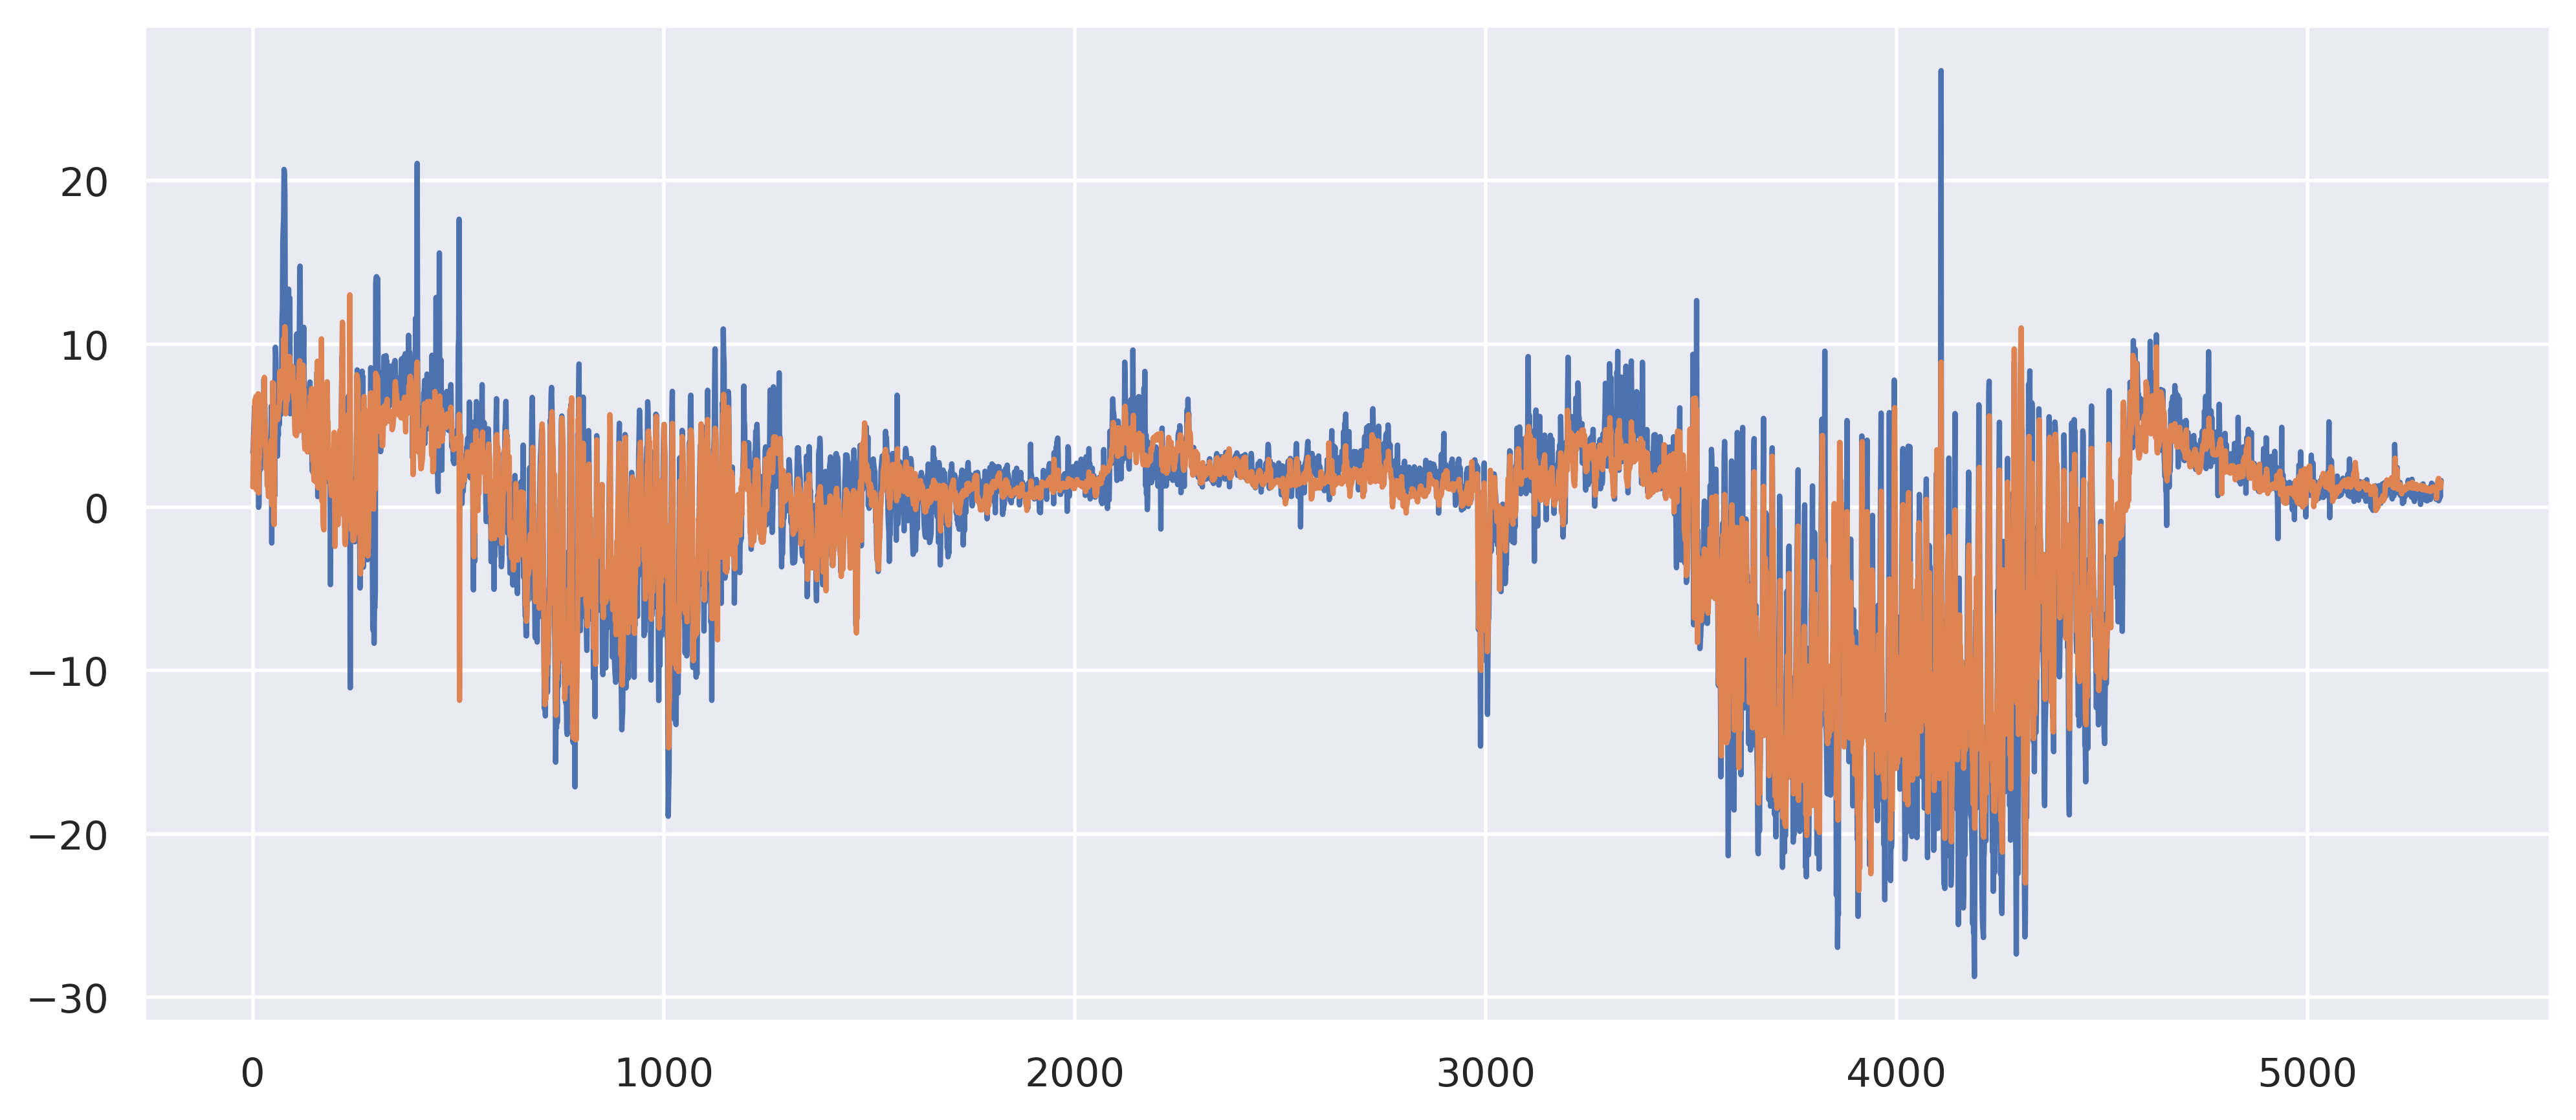

In [92]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt.nee)
ax.plot(preds.nee)
fig.savefig(save_dir.joinpath("nee_predictions.png"))

In [93]:
mask = (test_data["DateTime"].dt.month == 1).values

In [94]:
gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

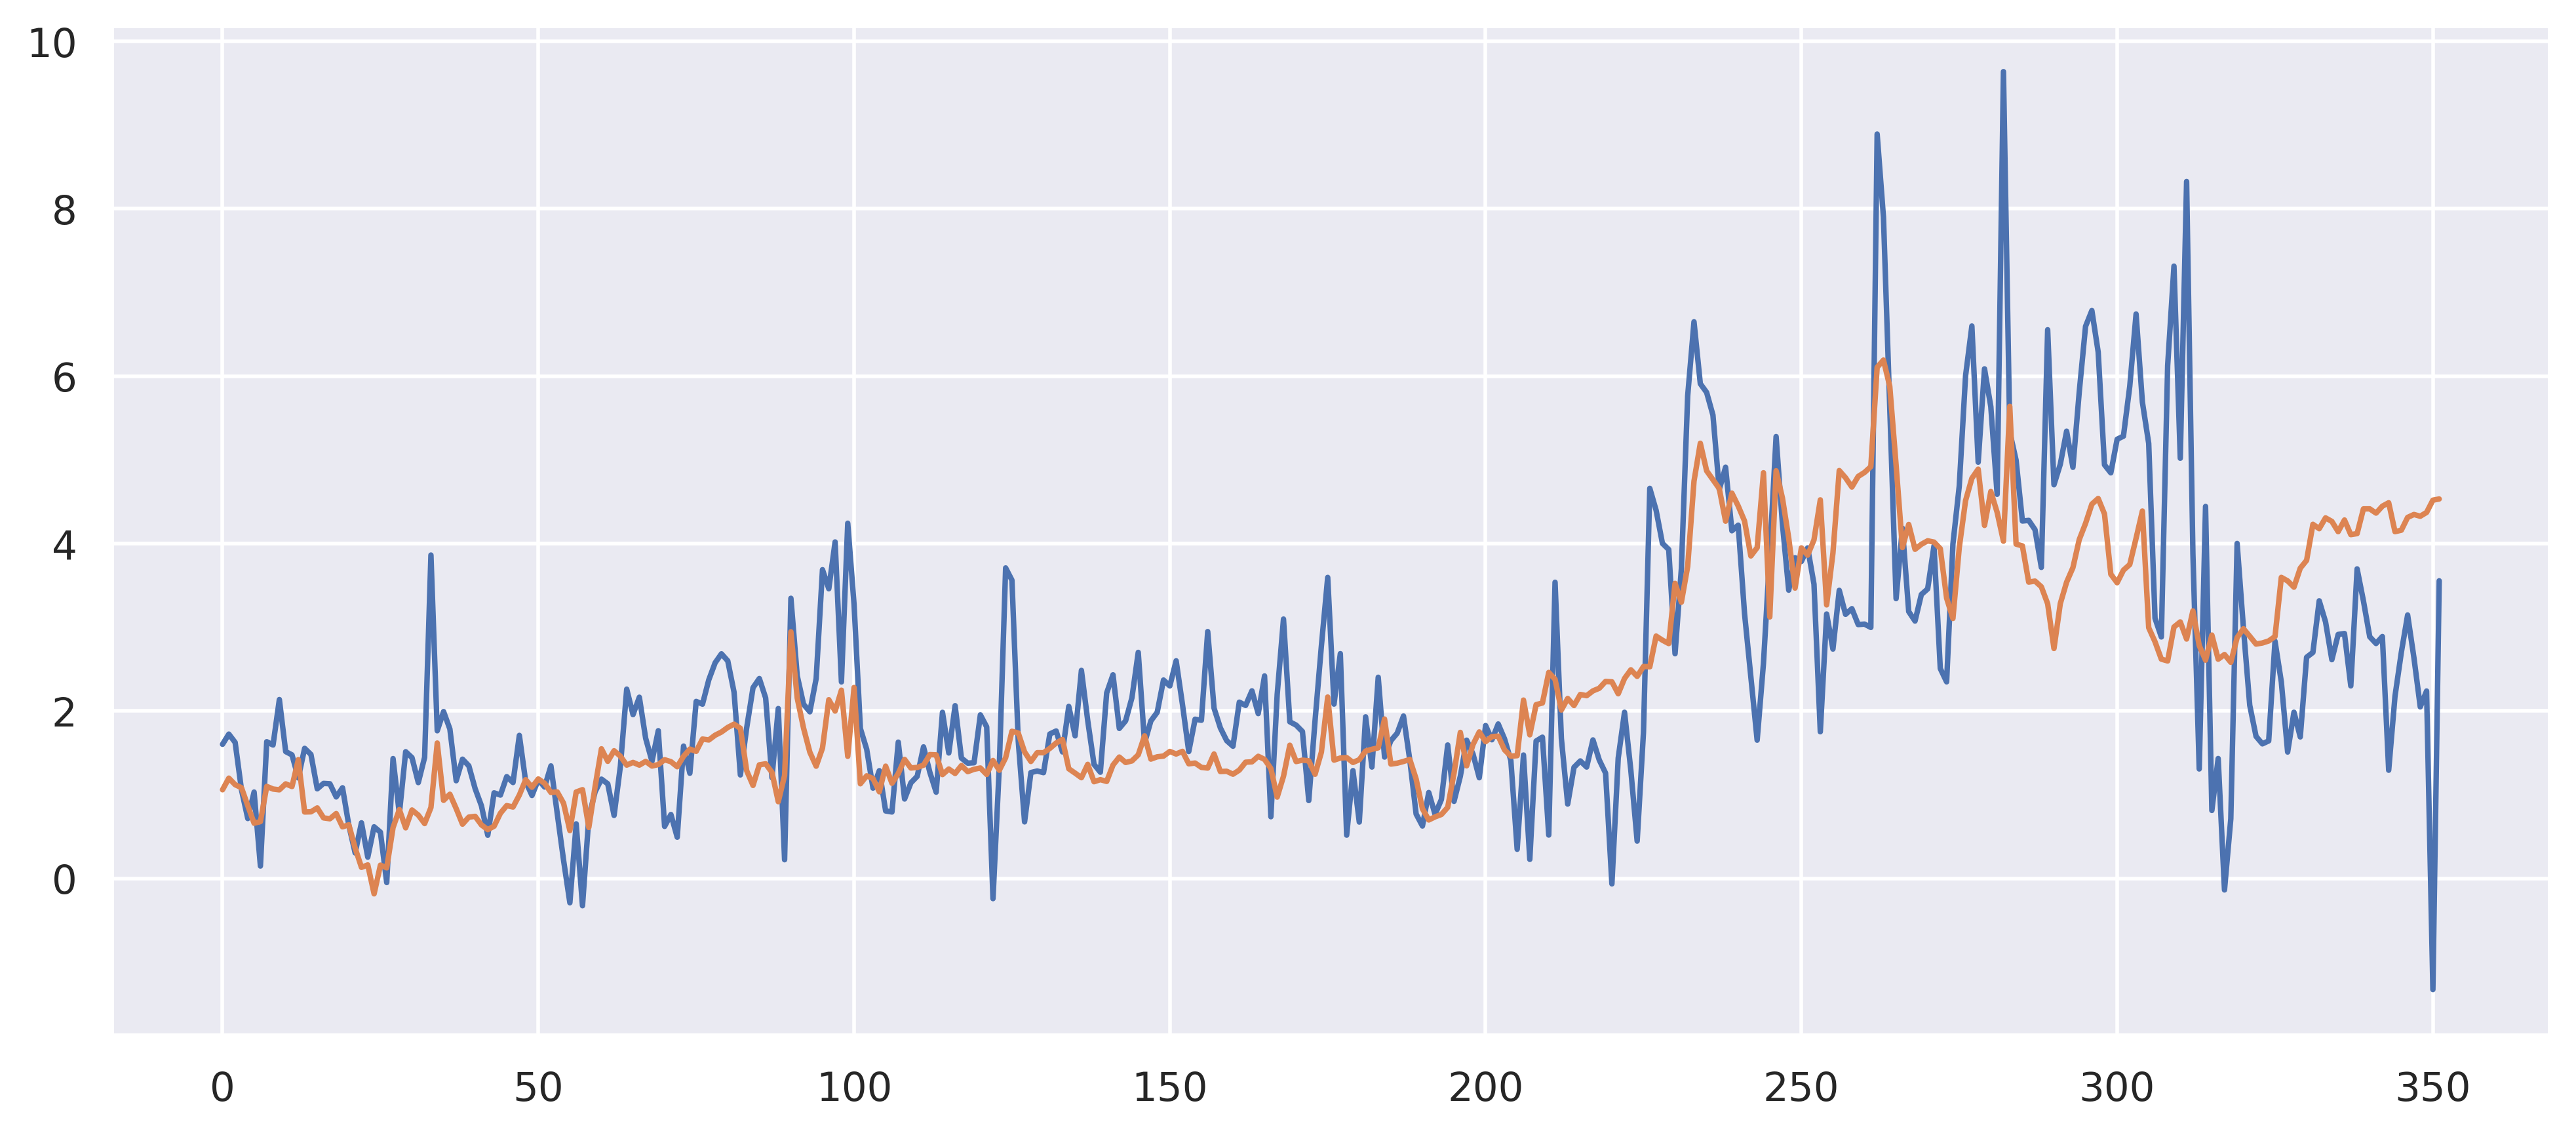

In [95]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis)
ax.plot(preds_vis)
fig.savefig(save_dir.joinpath("nee_predictions_month1.png"))

(0.0, 8.0)

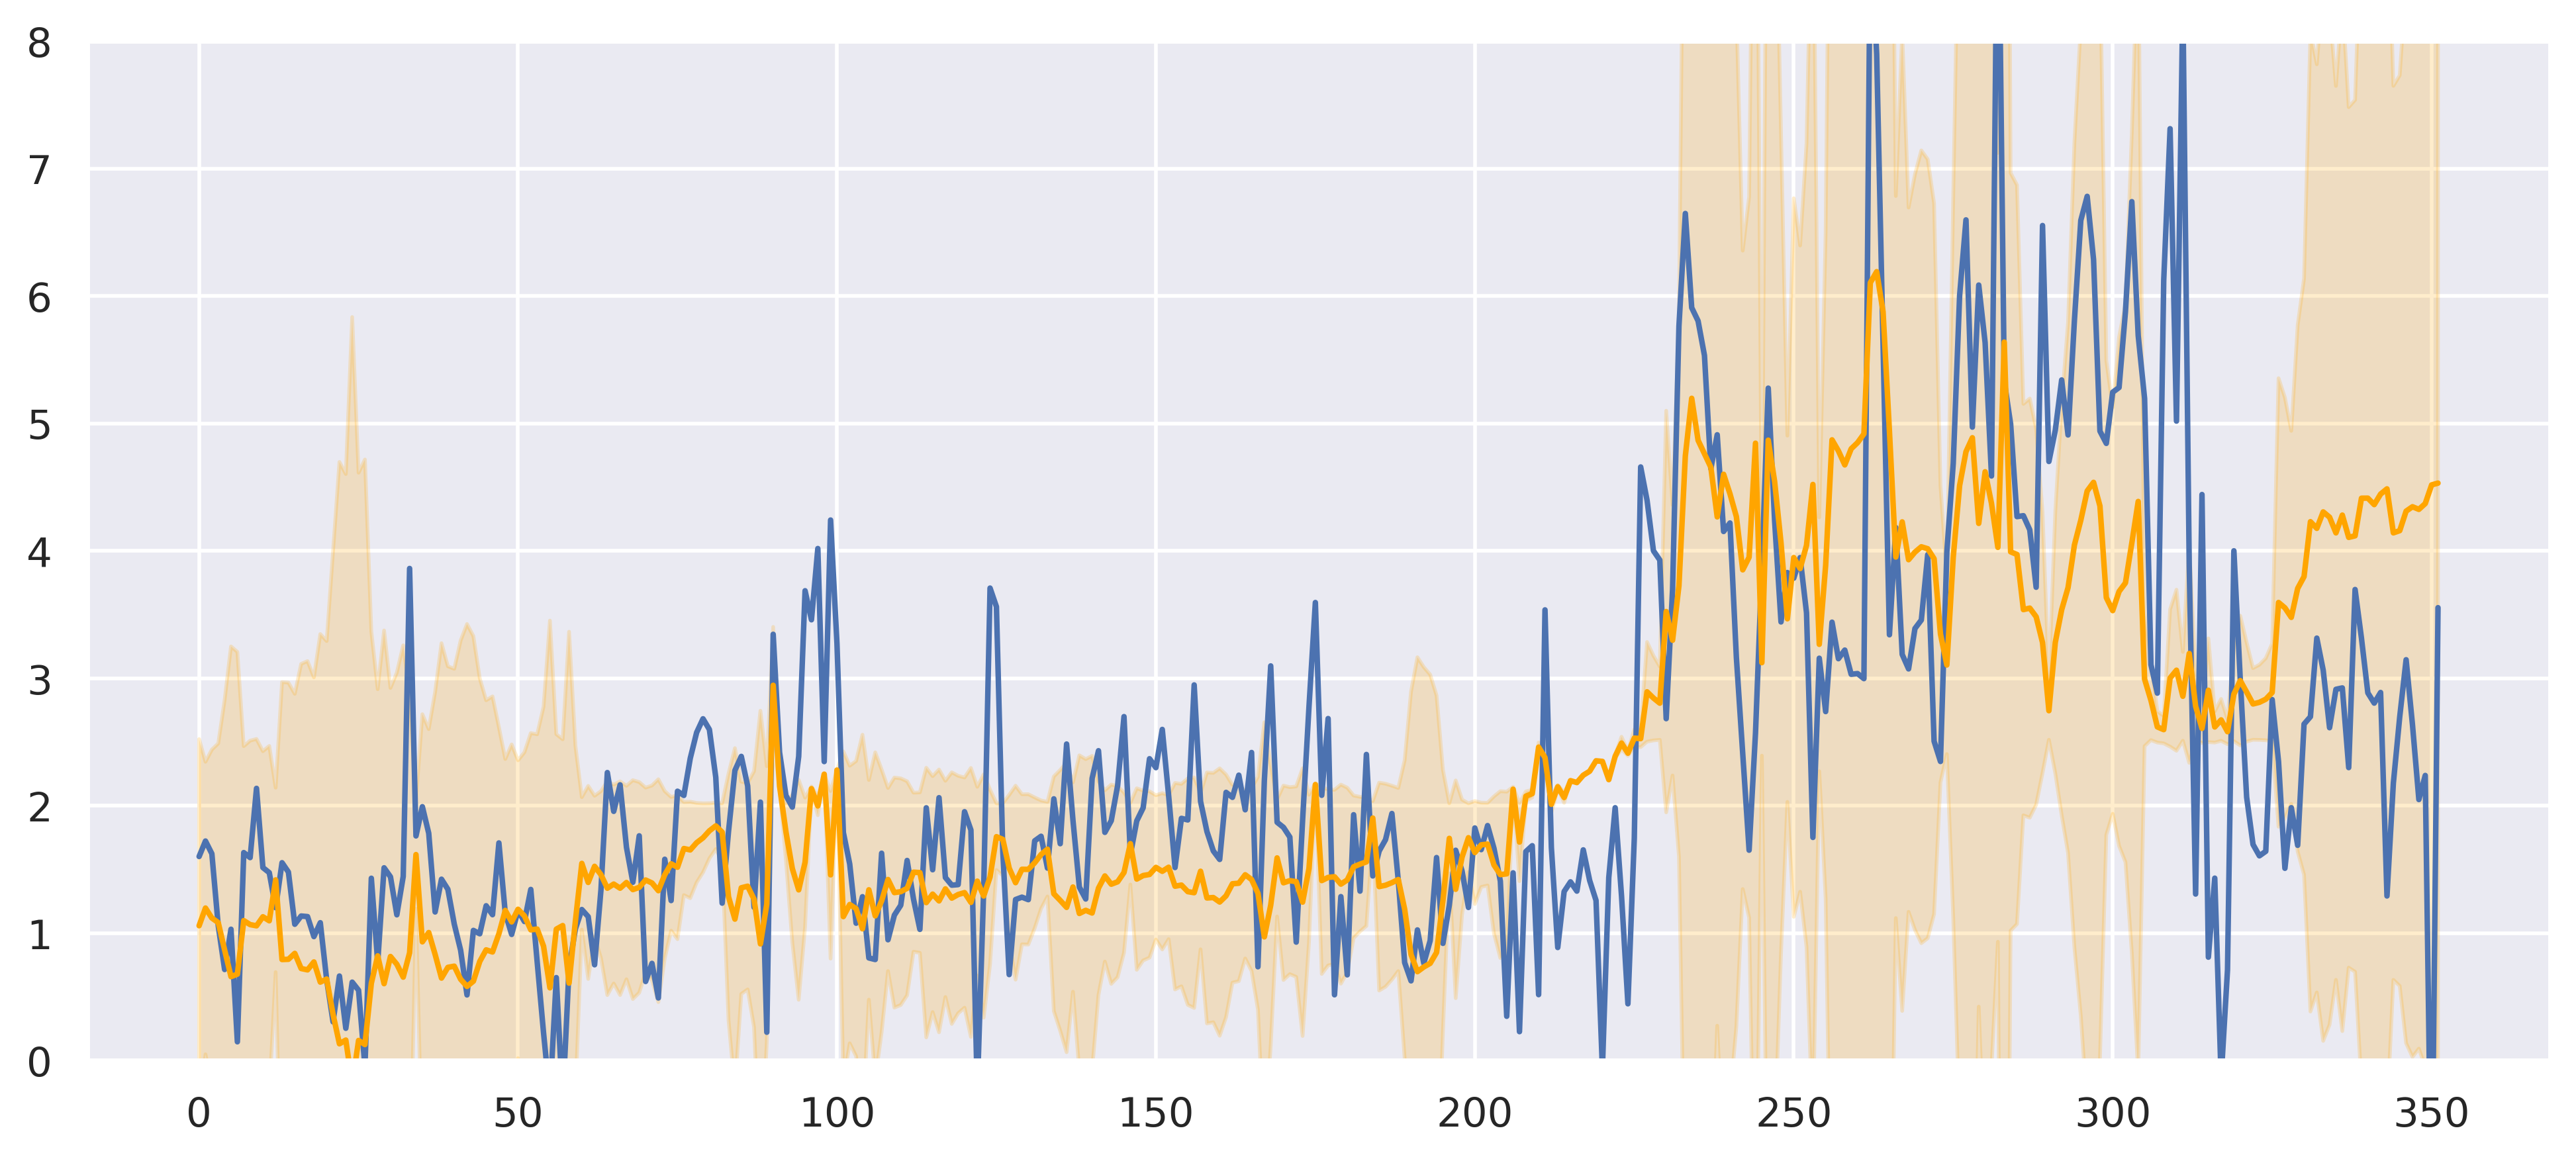

In [96]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
mu = np.mean(preds_vis)
error = np.square(preds_vis - mu)
ax.plot(gt_vis)
ax.plot(preds_vis, color="orange")
ax.fill_between(np.arange(preds_vis.shape[0]), preds_vis - error, preds_vis + error, alpha=0.2, color="orange")

ax.set_ylim(0, 8)

In [117]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

input_rfr = X_train[:,:-5]  #list(range(0, 15)) + [16, 17, 18, 19]
rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfr.fit(input_rfr, NEE_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [118]:
input_rfr = X_test[:,:-5]

preds_rfr = rfr.predict(input_rfr)
gt_rfr = NEE_test.values

In [119]:
mmd = compute_mmd(gt_rfr, preds_rfr)
wasstn = wasserstein_distance(gt_rfr, preds_rfr)
kl = compute_kl_divergence(gt_rfr, preds_rfr)
mae = mean_absolute_error(gt_rfr, preds_rfr)
r2 = r2_score(gt_rfr, preds_rfr)
print(colored("NEE", "blue"), "\nMMD: {}, Wasstn: {}, KL: {}, MAE: {}, R2: {}".format(mmd, wasstn, kl, mae, r2))

NEE 
MMD: 0.17720357318842345, Wasstn: 1.706914667107096, KL: 0.753953258641246, MAE: 3.2582453781774916, R2: 0.46884158644872675


In [120]:
gt_rfr_vis = gt_rfr[mask]
preds_rfr_vis = preds_rfr[mask]

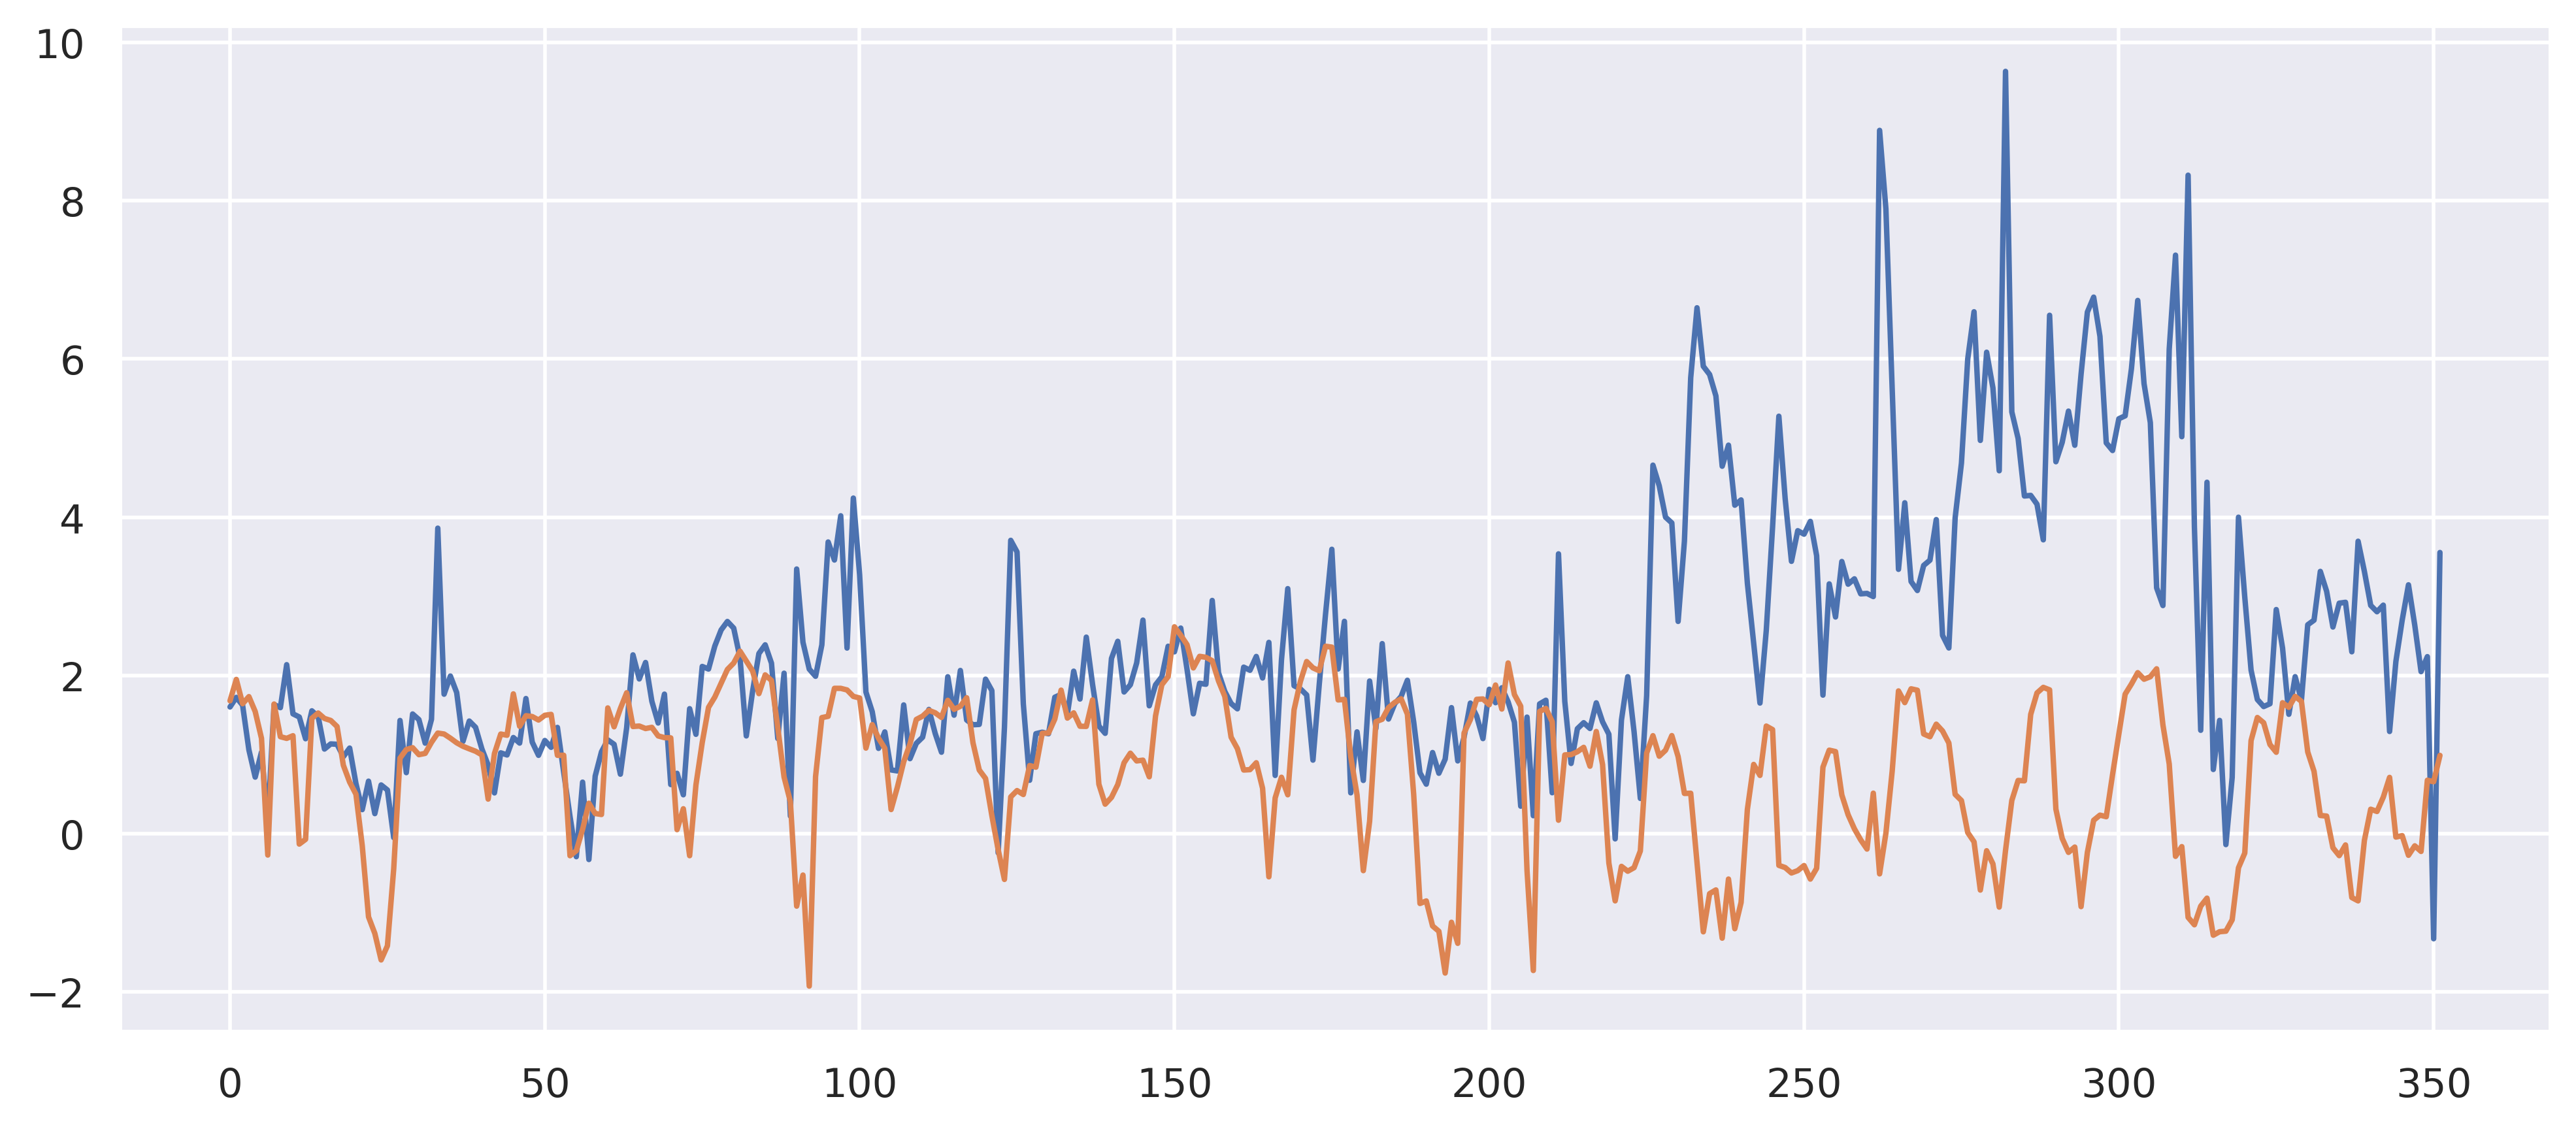

In [121]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
plt.plot(gt_rfr_vis)
plt.plot(preds_rfr_vis)

['Ta' 'H' 'Tau' 'LE_strg' 'RH' 'VPD' 'Rg' 'Ustar' 'Tsoil1' 'Tsoil2'
 'season' 'hour' 'dayofweek' 'month' 'dayofyear']


<BarContainer object of 15 artists>

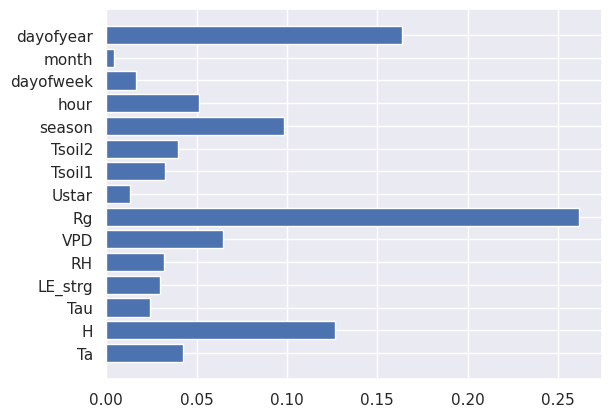

In [80]:
columns = drivers[:-5]
print(columns)
plt.barh(columns, rfr.feature_importances_)